# Predicting Ethereum Prices using LSTMs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv("ETH-USD.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,2.772120,164329.0
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,0.753325,674188.0
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,0.701897,532170.0
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,0.708448,405283.0
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.067860,1463100.0


In [3]:
df.shape

(2277, 7)

In [4]:
df.isnull().sum()

Date         0
Open         4
High         4
Low          4
Close        4
Adj Close    4
Volume       4
dtype: int64

In [5]:
df.dropna(axis=0,inplace=True)

In [6]:
df.isnull().sum()


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df[df['Close']!=df['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume


All values of `Close` and `Adj Close` are the same, so we can drop `Adj Close`.

In [8]:
df.drop('Adj Close',axis=1,inplace=True)

In [9]:
df['Day Change']=df['Close']-df['Open']

We engineer a feature `Day Change` to measure the amount by which the price of ETH has fluctuated in a day.

In [10]:
df.corr()

,Open,High,Low,Close,Volume,Day Change
Open,1.000000,0.999193,0.998129,0.997768,0.702089,0.031358
High,0.999193,1.000000,0.998028,0.998948,0.707808,0.061041
Low,0.998129,0.998028,1.000000,0.998930,0.689061,0.076648
Close,0.997768,0.998948,0.998930,1.000000,0.699612,0.098038
Volume,0.702089,0.707808,0.689061,0.699612,1.000000,0.008393
Day Change,0.031358,0.061041,0.076648,0.098038,0.008393,1.000000


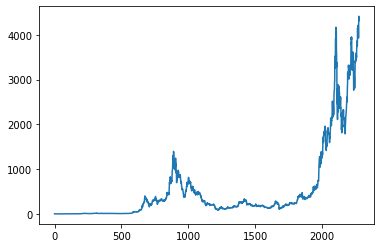

In [11]:
plt.plot(df['Close'])

There is high volatility in the prices of ETH, which spike briefly near the 1000th day mark and then shoot up after 2000th day. Splitting our dataset somewhere around the 1500-1800 mark for test would be a good way to proceed in the beginning. As we can observe from the correlation table, there is a high correlation between the `Open` and `Close` prices. This can help us predict the `Close` prices which is our target variable

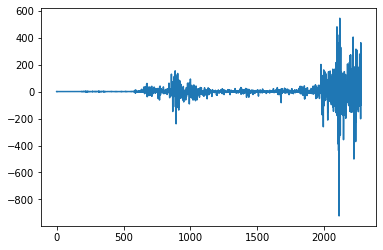

In [12]:
plt.plot(df['Day Change'])

In [13]:
df

,Date,Open,High,Low,Close,Volume,Day Change
0,2015-08-07,2.831620,3.536610,2.521120,2.772120,1.643290e+05,-0.059500
1,2015-08-08,2.793760,2.798810,0.714725,0.753325,6.741880e+05,-2.040435
2,2015-08-09,0.706136,0.879810,0.629191,0.701897,5.321700e+05,-0.004239
3,2015-08-10,0.713989,0.729854,0.636546,0.708448,4.052830e+05,-0.005541
4,2015-08-11,0.708087,1.131410,0.663235,1.067860,1.463100e+06,0.359773
...,...,...,...,...,...,...,...
2272,2021-10-26,4217.337891,4289.131348,4106.823730,4131.102051,1.715771e+10,-86.235840
2273,2021-10-27,4132.173340,4299.152832,3930.257324,3930.257324,2.621953e+10,-201.916016
2274,2021-10-28,3924.815430,4293.150879,3905.706055,4287.318848,2.595815e+10,362.503418
2275,2021-10-29,4288.686523,4455.735352,4271.707520,4414.746582,2.296764e+10,126.060059


In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler=MinMaxScaler()

In [16]:
def createData(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back)]['Close'].values
        X.append(a)
        y.append(data.iloc[i+look_back,5])
    return np.array(X), np.array(y)


In [17]:
X,y=createData(df,look_back=3)

In [18]:
X=scaler.fit_transform(X)

In [19]:
y=scaler.fit_transform(y.reshape(-1,1))

In [20]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [21]:
X_val, y_val = X[800:1200, :], y[800:1200]
X_train, y_train = X,y

In [22]:
X_train.shape

(2269, 1, 3)

In [23]:
y_train

array([[3.58836310e-06],
       [1.61094546e-05],
       [2.42474414e-05],
       ...,
       [3.10352225e-01],
       [3.07258391e-01],
       [2.71860508e-01]])

In [24]:
from keras import layers,models
from keras.callbacks import EarlyStopping

In [25]:
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [71]:
model=models.Sequential()

model.add(layers.LSTM(3,input_shape=(1,3)))
model.add(layers.Dense(2))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")


In [72]:
history=model.fit(X_train,y_train,epochs=50,batch_size=1,validation_batch_size=1,validation_data=(X_val,y_val))

Epoch 1/50
2269/2269 [==============================] - 7s 3ms/step - loss: 0.0094 - val_loss: 0.0055
Epoch 2/50
2269/2269 [==============================] - 6s 3ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 3/50
2269/2269 [==============================] - 7s 3ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 4/50
2269/2269 [==============================] - 6s 3ms/step - loss: 0.0088 - val_loss: 0.0074
Epoch 5/50
2269/2269 [==============================] - 6s 3ms/step - loss: 0.0085 - val_loss: 0.0063
Epoch 6/50
2269/2269 [==============================] - 6s 3ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 7/50
2269/2269 [==============================] - 6s 3ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 8/50
2269/2269 [==============================] - 6s 3ms/step - loss: 0.0086 - val_loss: 0.0097
Epoch 9/50
2269/2269 [==============================] - 6s 3ms/step - loss: 0.0085 - val_loss: 0.0069
Epoch 10/50
2269/2269 [==============================] - 6s 3ms/step - loss: 0.009

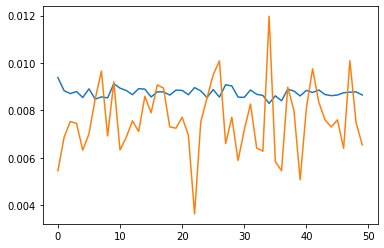

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [74]:
testPreds=model.predict(X_val)

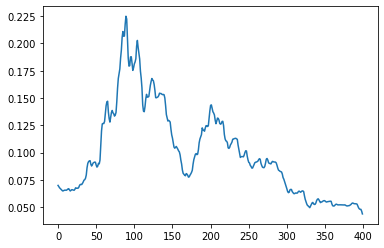

In [75]:

# plt.plot(y_val)
plt.plot(testPreds)
y_test = scaler.inverse_transform(y_val)
testPreds = scaler.inverse_transform(testPreds)

In [76]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [77]:
print(f"MAE: {mean_absolute_error(y_test,testPreds)}")
print(f"MSE: {mean_squared_error(y_test,testPreds)}")

MAE: 6278467949.16
MSE: 4.669884277888003e+19


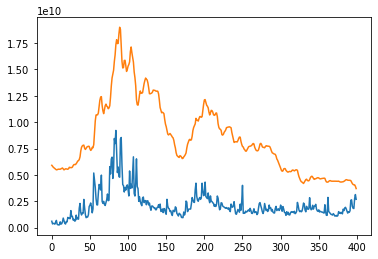

In [78]:
plt.plot(y_test)
plt.plot(testPreds)